In [ ]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import hilbert
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# 基本設定
subject_list = ["deyama_0527", "Kawabata_0625", "uchiyama_0702", "takahashi_0710",
                "irimajiri_0807", "terazawa_1022", "fukushima_1022", "aburatani_1118", "ueno_1121"]
compare_list = ["1st", "2nd"]  # 1st: 排便前, 2nd: 排便後
add_list = ["1ch", "2ch", "3ch", "4ch"]

data_dir = "/Volumes/NO NAME/蠕動音_排便前後/"

# 基本設定
sampling_rate = 3000  # サンプリング周波数 (Hz)
segment_duration_ms =  200  # セグメント長 (ms)
num_segments = 50  # 抽出するセグメント数
segment_samples = int(segment_duration_ms / 1000 * sampling_rate)  # 1セグメントのサンプル数
exclude_start_duration_sec = 300  # 最初に除外するデータの長さ (5分)
exclude_end_duration_sec = 5  # 最後に除外するデータの長さ (5秒)
min_interval_samples = 5 * sampling_rate  # 5秒 × サンプリング周波数

# 振幅包絡を計算する関数
def calculate_envelope(audio_data):
    analytic_signal = hilbert(audio_data)  # ヒルベルト変換
    envelope = np.abs(analytic_signal)  # 振幅包絡
    return envelope

# 特徴量抽出関数
def extract_features(segment, sampling_rate, num_bands=10, max_freq=1000):
    # RMS
    rms = np.sqrt(np.mean(segment**2))
    
    # 尖度 (Kurtosis)
    kurt = kurtosis(segment)
    
    # 歪度 (Skewness)
    skewness = skew(segment)
    
    # スペクトル重心とスペクトルロールオフ
    spectrum = np.fft.fft(segment)
    freqs = np.fft.fftfreq(len(segment), d=1/sampling_rate)
    positive_freqs = freqs[:len(freqs) // 2]
    positive_magnitude = np.abs(spectrum[:len(spectrum) // 2])
    spec_centroid = np.sum(positive_freqs * positive_magnitude) / np.sum(positive_magnitude)
    spec_rolloff = np.percentile(positive_freqs, 95)
    
    # 0-1000Hzを100Hz刻みにした帯域エネルギーを計算
    band_edges = np.arange(0, max_freq + 100, 100)
    stft_result = np.abs(np.fft.rfft(segment, n=segment_samples))**2
    freqs_stft = np.fft.rfftfreq(segment_samples, d=1/sampling_rate)
    band_energy = []
    for i in range(len(band_edges) - 1):
        band_mask = (freqs_stft >= band_edges[i]) & (freqs_stft < band_edges[i + 1])
        band_energy.append(np.sum(stft_result[band_mask]))
    
    # 信号の振幅が閾値を超えた/下回った時間割合
    threshold = 3 * np.std(segment)
    below_duration = np.sum(segment < threshold) / sampling_rate
    above_duration = np.sum(segment >= threshold) / sampling_rate
    
    # 特徴量をまとめて返す
    return [rms, kurt, skewness, spec_centroid, spec_rolloff] + band_energy + [below_duration, above_duration]

segmented_data = []  # セグメントデータを格納するリスト
labels = []  # ラベル ("before" または "after") を格納するリスト

# データの読み込みと処理
for subject in subject_list:
    for compare in compare_list:
        for channel in add_list:
            file_path = os.path.join(data_dir, f"{subject}_{compare}_{channel}_renoise.wav")
            if os.path.exists(file_path):
                _, audio_data = wavfile.read(file_path)  # WAVファイルの読み込み
                
                # 最初の5分と最後の5秒を除外
                start_idx = exclude_start_duration_sec * sampling_rate
                end_idx = len(audio_data) - exclude_end_duration_sec * sampling_rate
                audio_data = audio_data[start_idx:end_idx]
                
                # 振幅包絡を計算
                envelope = calculate_envelope(audio_data)

                # 標準偏差の 3 倍を超えた点を抽出
                threshold = np.mean(envelope) + 2 * np.std(envelope)
                significant_points = np.where(envelope > threshold)[0]
                
                if len(significant_points) > 0:
                    # 抽出した点を振幅包絡が大きい順に並べ替え
                    sorted_points = significant_points[np.argsort(envelope[significant_points])[::-1]]
                    
                    selected_points = []  # 重複を避けて選択されたセグメントの開始点を記録するリスト
                    
                    for point in sorted_points:
                        # 前後5秒以内に既存のセグメントがないか確認
                        if all(abs(point - sp) > min_interval_samples for sp in selected_points):
                            selected_points.append(point)
                            
                            # 指定されたセグメントを抽出（中心から前後100ms）
                            start_idx = max(0, point - segment_samples // 2)
                            end_idx = start_idx + segment_samples
                            if end_idx <= len(audio_data):
                                segment_window = audio_data[start_idx:end_idx]
                                segmented_data.append(segment_window)  # セグメントをリストに追加
                                labels.append("before" if compare == "1st" else "after")  # ラベルを追加
                            
                            # 50個に達したら終了
                            if len(selected_points) >= num_segments:
                                break
            else:
                print(f"File not found: {file_path}")  # ファイルが見つからなかった場合のエラーメッセージ

# 特徴量抽出
features = np.array([extract_features(seg, sampling_rate) for seg in segmented_data])

# 特徴量のスケーリング
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# NaNを列ごとの平均値で埋める
nan_indices = np.isnan(features_scaled)
if np.any(nan_indices):
    print(f"Number of NaNs: {np.sum(nan_indices)}")
    column_means = np.nanmean(features_scaled, axis=0)
    features_scaled[nan_indices] = np.take(column_means, np.where(nan_indices)[1])

/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

Best Method: Ward
Best Davies-Bouldin Score: 0.8330240606136095
Optimal Number of Clusters: 2
各クラス内の排便前 ('before') と排便後 ('after') のサンプル数:
Label    after  before
Cluster               
0         1796    1792
1            2       7

各クラス内の排便前 ('before') と排便後 ('after') の割合 (%):
Label        after     before
Cluster                      
0        50.055741  49.944259
1        22.222222  77.777778


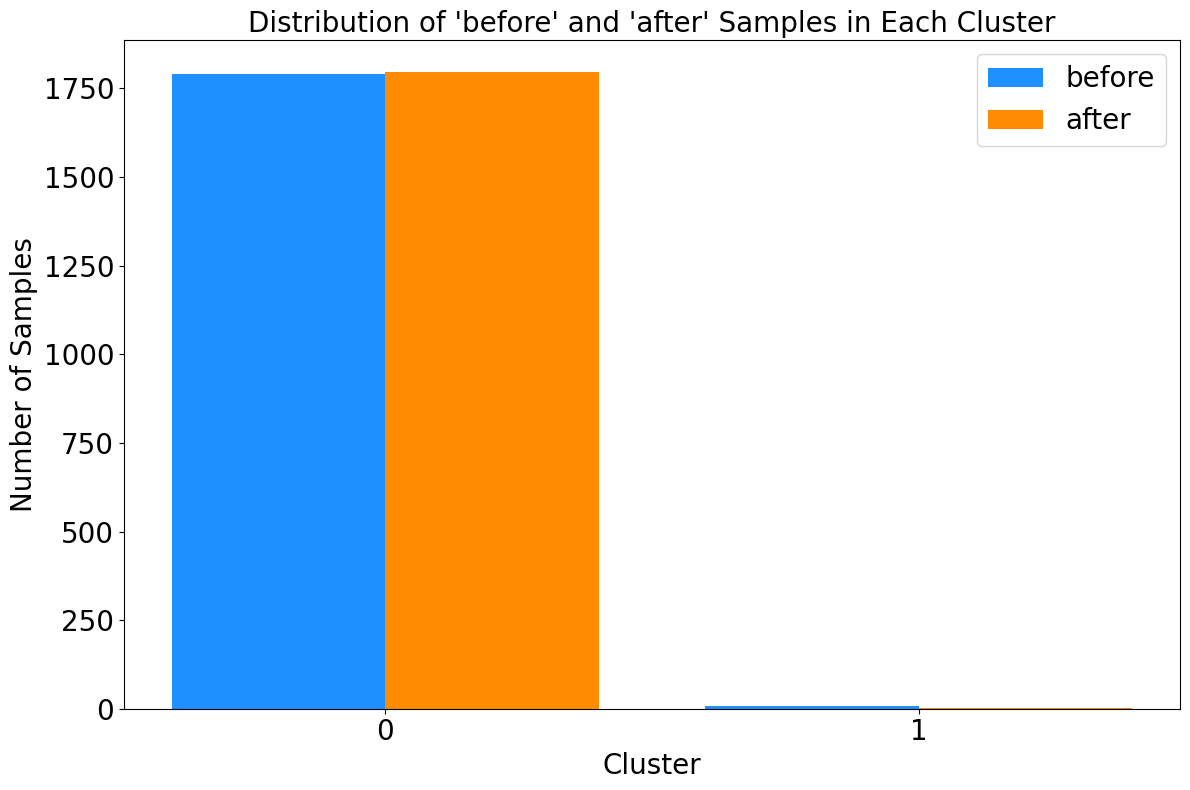

In [13]:
import pandas as pd
# **教師なしクラスタリング**
# クラスタリング手法と評価を設定
cluster_methods = {
    "KMeans": lambda n: KMeans(n_clusters=n, random_state=0).fit(features_scaled).labels_,
    "GaussianMixture": lambda n: GaussianMixture(n_components=n, random_state=0).fit_predict(features_scaled),
    "Ward": lambda n: AgglomerativeClustering(n_clusters=n, linkage="ward").fit_predict(features_scaled)
}

best_method, best_score, best_clusters, best_n_clusters = None, float("inf"), None, None

for method_name, cluster_func in cluster_methods.items():
    for n_clusters in range(2, 6):
        try:
            clusters = cluster_func(n_clusters)
            score = davies_bouldin_score(features_scaled, clusters)
            if score < best_score:
                best_method = method_name
                best_score = score
                best_clusters = clusters
                best_n_clusters = n_clusters
        except Exception as e:
            print(f"Error in {method_name} with n_clusters={n_clusters}: {e}")

# 結果の表示
print(f"Best Method: {best_method}")
print(f"Best Davies-Bouldin Score: {best_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")

# クラスターラベルと排便前後のラベルをデータフレームに格納
data_df = pd.DataFrame({
    'Cluster': best_clusters,
    'Label': labels  # "before" または "after" のリスト
})

# 各クラスタ内のラベル分布を集計
class_distribution = data_df.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)

# 結果の出力
print("各クラス内の排便前 ('before') と排便後 ('after') のサンプル数:")
print(class_distribution)

# 各クラスの割合を計算して表示
class_distribution_percentage = class_distribution.div(class_distribution.sum(axis=1), axis=0) * 100
print("\n各クラス内の排便前 ('before') と排便後 ('after') の割合 (%):")
print(class_distribution_percentage)

# クラスタリング結果を棒グラフで表示
clusters = class_distribution.index
before_counts = class_distribution['before']
after_counts = class_distribution['after']

bar_width = 0.4
x = np.arange(len(clusters))

plt.figure(figsize=(12, 8))
plt.bar(x - bar_width / 2, before_counts, width=bar_width, color='dodgerblue', label='before')
plt.bar(x + bar_width / 2, after_counts, width=bar_width, color='darkorange', label='after')

plt.xlabel("Cluster", fontsize=20)
plt.ylabel("Number of Samples", fontsize=20)
plt.title("Distribution of 'before' and 'after' Samples in Each Cluster", fontsize=20)
plt.xticks(x, clusters, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()


In [14]:
print(f"Number of selected segments for {file_path}: {len(selected_points)}")
print(f"Total number of segments: {len(segmented_data)}")
print(f"Total number of labels: {len(labels)}")

Number of selected segments for /Volumes/NO NAME/蠕動音_排便前後/ueno_1121_2nd_4ch_renoise.wav: 50
Total number of segments: 3597
Total number of labels: 3597


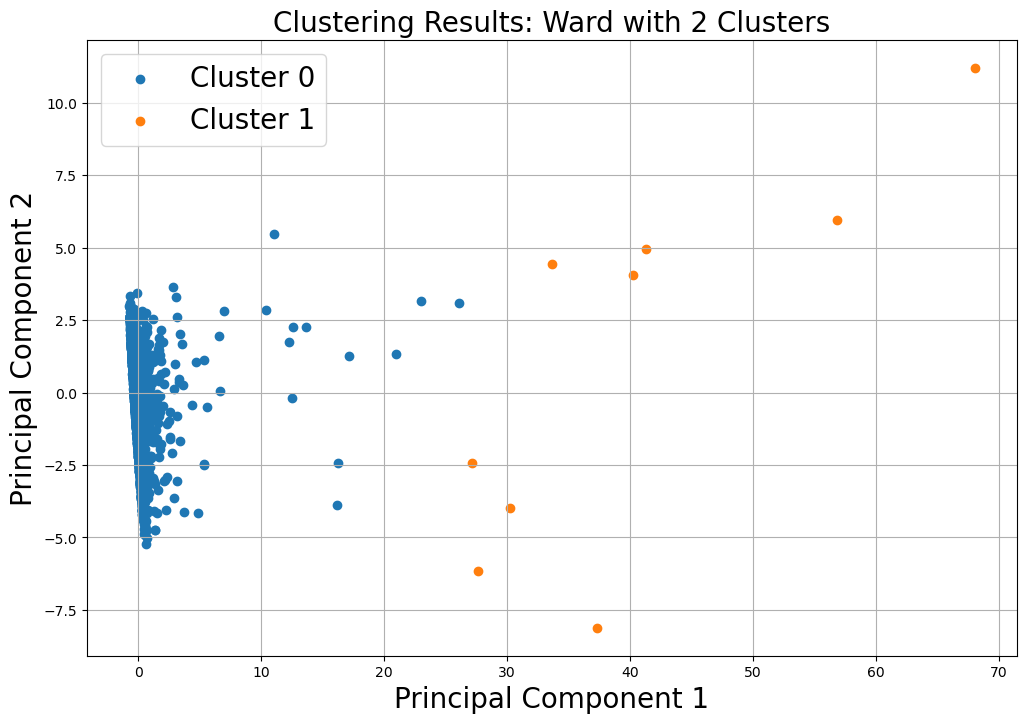


PC1 (Explained Variance: 35.73%):
Band 800-900Hz: 0.3649
Band 900-1000Hz: 0.3378
Band 200-300Hz: 0.3259
Band 100-200Hz: 0.3231
Band 700-800Hz: 0.3224
Band 300-400Hz: 0.3103
Band 500-600Hz: 0.3094
Band 600-700Hz: 0.3009
Band 0-100Hz: 0.2759
Band 400-500Hz: 0.2378
Above Threshold: 0.0988
Below Threshold: -0.0988
Kurtosis: -0.0451
RMS: 0.0384
Spectral Centroid: -0.0081
Skewness: -0.0010
Spectral Rolloff: -0.0000

PC2 (Explained Variance: 14.79%):
Above Threshold: -0.5690
Below Threshold: 0.5690
Spectral Centroid: 0.3944
Kurtosis: 0.3283
RMS: -0.1887
Band 500-600Hz: 0.1034
Band 600-700Hz: 0.0997
Band 700-800Hz: 0.0827
Band 400-500Hz: 0.0779
Band 300-400Hz: 0.0712
Band 100-200Hz: -0.0633
Band 800-900Hz: 0.0594
Band 0-100Hz: -0.0592
Band 900-1000Hz: 0.0398
Skewness: 0.0370
Band 200-300Hz: 0.0312
Spectral Rolloff: 0.0000

Number of components to explain 80% variance: 8
Cumulative Explained Variance Ratio: [0.35729205 0.50518454 0.60300268 0.68103863 0.75672881 0.82059832
 0.86843871 0.909164

In [41]:
# **次元削減 (PCA)**
pca = PCA(n_components=None)  # すべての成分を保持して実行
pca.fit(features_scaled)
features_2d = pca.transform(features_scaled)

plt.figure(figsize=(12, 8))
for cluster_id in np.unique(best_clusters):
    points = features_2d[best_clusters == cluster_id]
    plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {cluster_id}")
plt.title(f"Clustering Results: {best_method} with {best_n_clusters} Clusters", fontsize=20)
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

# PCAで特徴量の寄与度を解析
loadings = pca.components_  # 主成分負荷量 (shape: [n_components, n_features])
explained_variance = pca.explained_variance_ratio_  # 寄与率

# 特徴量ラベル
feature_labels = ["RMS", "Kurtosis", "Skewness", "Spectral Centroid", "Spectral Rolloff"] + \
                 [f"Band {i * 100}-{(i + 1) * 100}Hz" for i in range(10)] + \
                 ["Below Threshold", "Above Threshold"]

# PC1とPC2に寄与する特徴量を表示
for i, pc_label in enumerate(["PC1", "PC2"]):
    print(f"\n{pc_label} (Explained Variance: {explained_variance[i] * 100:.2f}%):")
    sorted_indices = np.argsort(np.abs(loadings[i]))[::-1]  # 寄与度の高い順にソート
    for idx in sorted_indices:
        print(f"{feature_labels[idx]}: {loadings[i, idx]:.4f}")

# ラベルのエンコード
y = np.array(labels)
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

# 累積寄与率を計算
cumulative_explained_variance = np.cumsum(explained_variance)

# 70%以上の分散を説明するための成分数を決定
n_components_for_80 = np.argmax(cumulative_explained_variance >= 0.9) + 1
print(f"\nNumber of components to explain 80% variance: {n_components_for_80}")

# PCAを再度実行して、最適な成分数で次元削減
pca = PCA(n_components=n_components_for_80)
features_2d = pca.fit_transform(features_scaled)

# **PCAの結果表示**
print("Cumulative Explained Variance Ratio:", cumulative_explained_variance)

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(features_2d, y_encoded, test_size=0.2, random_state=42)

# ランダムフォレスト分類器
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(
    n_estimators=100,       # 弱学習器の数
    learning_rate=0.1,      # 学習率
    max_depth=3,            # 各決定木の深さ
    random_state=42
)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.6028
Precision: 0.6109
Recall: 0.6028
F1 Score: 0.5980


In [44]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.5819
Precision: 0.5829
Recall: 0.5819
F1 Score: 0.5817


In [47]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.6167
Precision: 0.6183
Recall: 0.6167
F1 Score: 0.6162


In [49]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.6333
Precision: 0.6347
Recall: 0.6333
F1 Score: 0.6331


In [51]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [52]:
from xgboost import XGBClassifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)

# 予測結果
y_pred = clf.predict(X_test)

# 精度評価
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 結果表示
print("Gradient Boosting Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Classification Performance:
Accuracy: 0.5819
Precision: 0.5823
Recall: 0.5819
F1 Score: 0.5820


/Users/a81802/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:23:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [24]:
# クラスタリング手法と評価を設定
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

cluster_methods = {
    "KMeans": lambda n: KMeans(n_clusters=n, random_state=0).fit(features_scaled).labels_,
    "GaussianMixture": lambda n: GaussianMixture(n_components=n, random_state=0).fit_predict(features_scaled),
    "Ward": lambda n: AgglomerativeClustering(n_clusters=n, linkage="ward").fit_predict(features_scaled)
}

best_method, best_score, best_clusters, best_n_clusters = None, float("inf"), None, None

for method_name, cluster_func in cluster_methods.items():
    for n_clusters in range(2, 6):
        try:
            clusters = cluster_func(n_clusters)
            score = davies_bouldin_score(features_scaled, clusters)
            if score < best_score:
                best_method = method_name
                best_score = score
                best_clusters = clusters
                best_n_clusters = n_clusters
        except Exception as e:
            print(f"Error in {method_name} with n_clusters={n_clusters}: {e}")

# 結果の表示
print(f"Best Method: {best_method}")
print(f"Best Davies-Bouldin Score: {best_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")

# Calinski-Harabaszスコアを計算
ch_score = calinski_harabasz_score(features_scaled, best_clusters)
print(f"Calinski-Harabasz Score: {ch_score:.2f}")

# Silhouetteスコアを計算
sil_score = silhouette_score(features_scaled, best_clusters)
print(f"Silhouette Score: {sil_score:.2f}")

import pandas as pd

# クラスターラベルと排便前後のラベルをデータフレームに格納
data_df = pd.DataFrame({
    'Cluster': best_clusters,
    'Label': labels  # "before" または "after" のリスト
})

# 各クラス内のラベル分布を集計
class_distribution = data_df.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)

# 結果の出力
print("各クラス内の排便前 ('before') と排便後 ('after') のサンプル数:")
print(class_distribution)

# Optional: 各クラスの割合を計算して表示
class_distribution_percentage = class_distribution.div(class_distribution.sum(axis=1), axis=0) * 100
print("\n各クラス内の排便前 ('before') と排便後 ('after') の割合 (%):")
print(class_distribution_percentage)

/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/a81802/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

Best Method: Ward
Best Davies-Bouldin Score: 0.8330240606136095
Optimal Number of Clusters: 2
Calinski-Harabasz Score: 1317.31
Silhouette Score: 0.93
各クラス内の排便前 ('before') と排便後 ('after') のサンプル数:
Label    after  before
Cluster               
0         1796    1792
1            2       7

各クラス内の排便前 ('before') と排便後 ('after') の割合 (%):
Label        after     before
Cluster                      
0        50.055741  49.944259
1        22.222222  77.777778


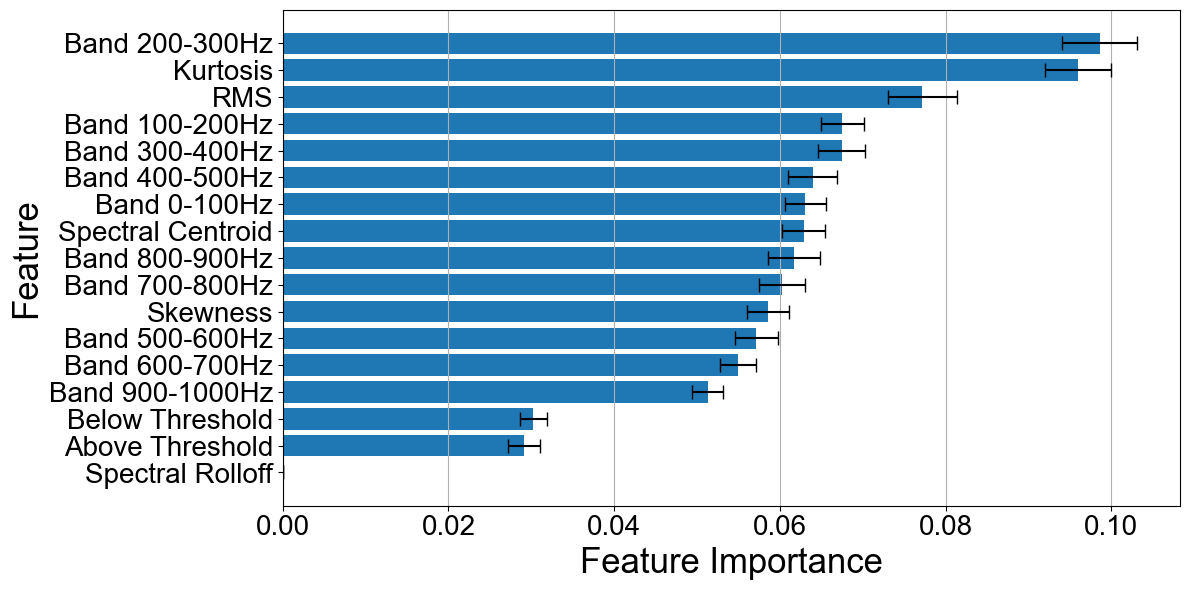

In [26]:
# **特徴量重要度のブートストラップ分析**
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
# パラメータ設定
n_bootstraps = 100  # ブートストラップの回数

# 特徴量重要度を記録するリスト
importances_list = []

# ブートストラップサンプリングを繰り返しランダムフォレストを学習
for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(features_scaled, y_encoded)  # 元の特徴量を使用
    clf_bootstrap = RandomForestClassifier(random_state=42)
    clf_bootstrap.fit(X_resampled, y_resampled)
    importances_list.append(clf_bootstrap.feature_importances_)

# 各特徴量の平均と標準偏差を計算
importances_mean = np.mean(importances_list, axis=0)
importances_std = np.std(importances_list, axis=0)

# 小さい順にソート
sorted_indices = np.argsort(importances_mean)
sorted_labels = [feature_labels[i] for i in sorted_indices]
sorted_importances = importances_mean[sorted_indices]
sorted_std = importances_std[sorted_indices]

# 重要度のプロット（エラーバー付き）
plt.figure(figsize=(12, 6))
plt.barh(sorted_labels, sorted_importances, xerr=sorted_std, align='center', capsize=5)
plt.xlabel("Feature Importance", fontsize=25)
plt.ylabel("Feature", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

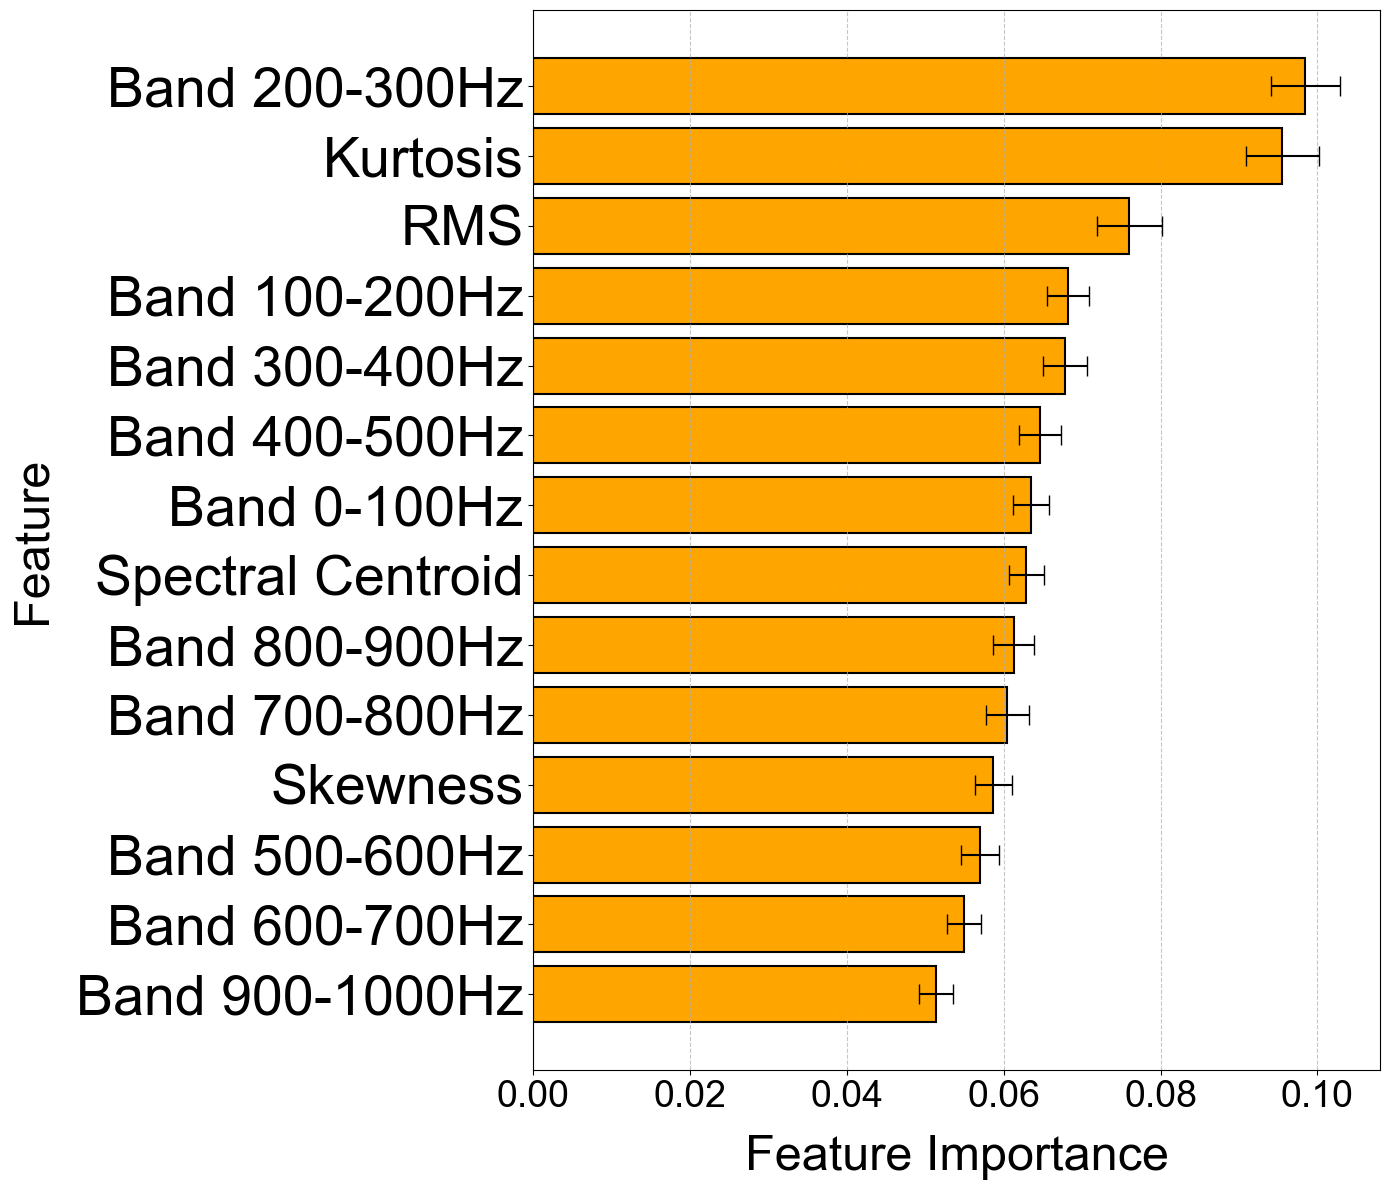

In [27]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# **特徴量重要度のブートストラップ分析**
# パラメータ設定
n_bootstraps = 100  # ブートストラップの回数

# 特徴量重要度を記録するリスト
importances_list = []

# ブートストラップサンプリングを繰り返しランダムフォレストを学習
for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(features_scaled, y_encoded)  # 元の特徴量を使用
    clf_bootstrap = RandomForestClassifier(random_state=42)
    clf_bootstrap.fit(X_resampled, y_resampled)
    importances_list.append(clf_bootstrap.feature_importances_)

# 各特徴量の平均と標準偏差を計算
importances_mean = np.mean(importances_list, axis=0)
importances_std = np.std(importances_list, axis=0)

# 重要度が 0.05を超えたものをフィルタ
threshold = 0.05
filtered_indices = np.where(importances_mean > threshold)[0]
filtered_labels = [feature_labels[i] for i in filtered_indices]
filtered_importances = importances_mean[filtered_indices]
filtered_std = importances_std[filtered_indices]

# 小さい順にソート
sorted_indices = np.argsort(filtered_importances)
sorted_labels = [filtered_labels[i] for i in sorted_indices]
sorted_importances = filtered_importances[sorted_indices]
sorted_std = filtered_std[sorted_indices]

# フォント設定をArialに変更
rcParams['font.family'] = 'Arial'

# 重要度のプロット（エラーバー付き）
plt.figure(figsize=(14, 12))
plt.barh(
    sorted_labels, 
    sorted_importances, 
    xerr=sorted_std, 
    align='center', 
    capsize=7,  # エラーバーの端のキャップサイズ
    color='Orange', 
    edgecolor='black', 
    linewidth=1.5
)

# 軸ラベルとフォントサイズ
plt.xlabel("Feature Importance", fontsize=35, labelpad=15)
plt.ylabel("Feature", fontsize=35, labelpad=15)

# 軸の目盛りフォントサイズ
plt.xticks(fontsize=27)
plt.yticks(fontsize=40)

# グリッド線をx軸に追加
plt.grid(axis='x', linestyle='--', alpha=0.7)

# レイアウト調整
plt.tight_layout()

# グラフの表示
plt.show()

In [29]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import hilbert

# 基本設定
subject_list = ["deyama_0527", "Kawabata_0625", "uchiyama_0702", "takahashi_0710",
                "irimajiri_0807", "terazawa_1022", "fukushima_1022", "aburatani_1118", "ueno_1121"]
compare_list = ["1st", "2nd"]  # 1st: 排便前, 2nd: 排便後
add_list = ["1ch", "2ch", "3ch", "4ch"]

data_dir = "/Volumes/NO NAME/蠕動音_排便前後/"

# 基本設定
sampling_rate = 3000  # サンプリング周波数 (Hz)
segment_duration_ms = 200  # セグメント長 (ms)
segment_samples = int(segment_duration_ms / 1000 * sampling_rate)  # 1セグメントのサンプル数
exclude_start_duration_sec = 300  # 最初に除外するデータの長さ (5分)
exclude_end_duration_sec = 5  # 最後に除外するデータの長さ (5秒)
min_interval_samples = 5 * sampling_rate  # 5秒 × サンプリング周波数

# 振幅包絡を計算する関数
def calculate_envelope(audio_data):
    analytic_signal = hilbert(audio_data)  # ヒルベルト変換
    envelope = np.abs(analytic_signal)  # 振幅包絡
    return envelope

# セグメント数をカウントする辞書
segment_count = {}

# データの読み込みと処理
for subject in subject_list:
    for compare in compare_list:
        for channel in add_list:
            file_path = os.path.join(data_dir, f"{subject}_{compare}_{channel}_renoise.wav")
            if os.path.exists(file_path):
                _, audio_data = wavfile.read(file_path)  # WAVファイルの読み込み
                
                # 最初の5分と最後の5秒を除外
                start_idx = exclude_start_duration_sec * sampling_rate
                end_idx = len(audio_data) - exclude_end_duration_sec * sampling_rate
                audio_data = audio_data[start_idx:end_idx]
                
                # 振幅包絡を計算
                envelope = calculate_envelope(audio_data)

                # 標準偏差の 3 倍を超えた点を抽出
                threshold = np.mean(envelope) + 2 * np.std(envelope)
                significant_points = np.where(envelope > threshold)[0]
                
                if len(significant_points) > 0:
                    # 抽出した点を振幅包絡が大きい順に並べ替え
                    sorted_points = significant_points[np.argsort(envelope[significant_points])[::-1]]
                    
                    selected_points = []  # 重複を避けて選択されたセグメントの開始点を記録するリスト
                    
                    for point in sorted_points:
                        # 前後5秒以内に既存のセグメントがないか確認
                        if all(abs(point - sp) > min_interval_samples for sp in selected_points):
                            selected_points.append(point)
                            
                            # セグメント数を辞書に記録
                            key = (subject, channel, compare)
                            segment_count[key] = segment_count.get(key, 0) + 1
                            
                            # 50個に達したら終了
                            if len(selected_points) >= 50:
                                break
            else:
                print(f"File not found: {file_path}")  # ファイルが見つからなかった場合のエラーメッセージ

# セグメント数の表示
print("\n抽出されたセグメント数（各 subject, channel, compare ごと）:")
for key, count in segment_count.items():
    subject, channel, compare = key
    print(f"Subject: {subject}, Channel: {channel}, Compare: {compare} -> Segments: {count}")


抽出されたセグメント数（各 subject, channel, compare ごと）:
Subject: deyama_0527, Channel: 1ch, Compare: 1st -> Segments: 50
Subject: deyama_0527, Channel: 2ch, Compare: 1st -> Segments: 50
Subject: deyama_0527, Channel: 3ch, Compare: 1st -> Segments: 50
Subject: deyama_0527, Channel: 4ch, Compare: 1st -> Segments: 50
Subject: deyama_0527, Channel: 1ch, Compare: 2nd -> Segments: 50
Subject: deyama_0527, Channel: 2ch, Compare: 2nd -> Segments: 50
Subject: deyama_0527, Channel: 3ch, Compare: 2nd -> Segments: 50
Subject: deyama_0527, Channel: 4ch, Compare: 2nd -> Segments: 50
Subject: Kawabata_0625, Channel: 1ch, Compare: 1st -> Segments: 50
Subject: Kawabata_0625, Channel: 2ch, Compare: 1st -> Segments: 50
Subject: Kawabata_0625, Channel: 3ch, Compare: 1st -> Segments: 50
Subject: Kawabata_0625, Channel: 4ch, Compare: 1st -> Segments: 50
Subject: Kawabata_0625, Channel: 1ch, Compare: 2nd -> Segments: 50
Subject: Kawabata_0625, Channel: 2ch, Compare: 2nd -> Segments: 50
Subject: Kawabata_0625, Channel: